In [2]:
import numpy as np
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister
import matplotlib
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from IPython.display import display, Math

In [3]:
simulator = Aer.get_backend('qasm_simulator')

# 1.a

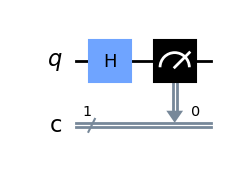

In [4]:
circ = QuantumCircuit(1, 1)
circ.h(0)
circ.measure(range(1), range(1))
circ.draw('mpl')

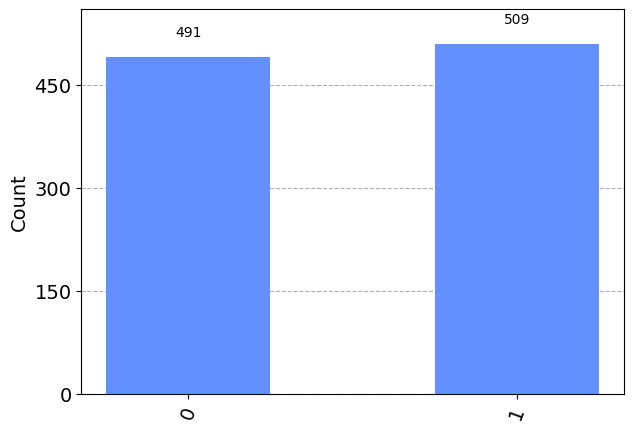

In [5]:
job = execute(circ , simulator , shots=1000)
result = job.result()
counts = result.get_counts(circ)
plot_histogram(counts)

# 1.b - Bell state $\left|B_{00}\right>_2$

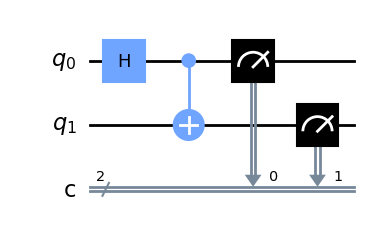

In [6]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(range(2), range(2))
circ.draw('mpl')

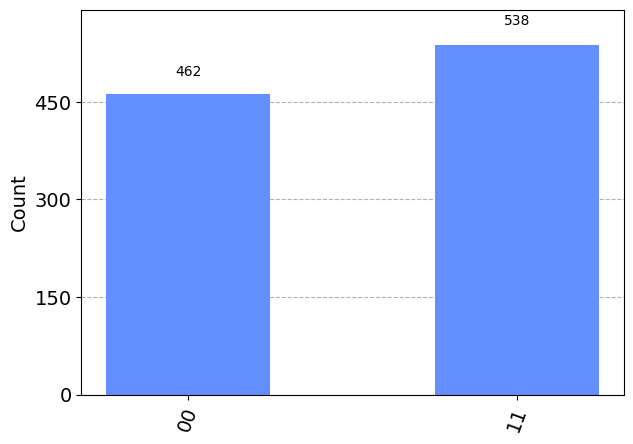

In [7]:
job = execute(circ , simulator , shots=1000)
result = job.result()
counts = result.get_counts(circ)
plot_histogram(counts)

# 2

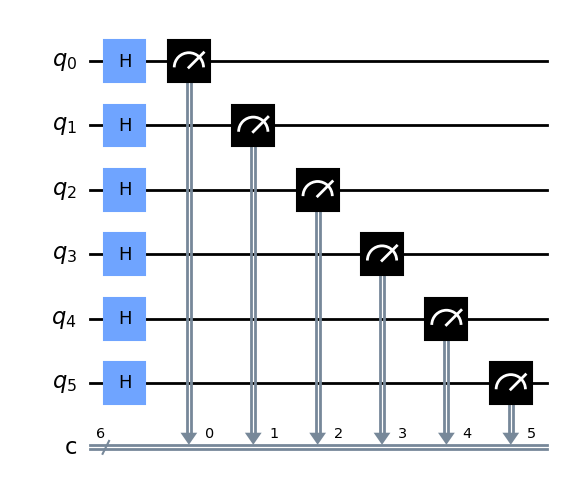

In [8]:
n_qbits = 6
circ = QuantumCircuit(n_qbits, n_qbits)
for i in range(n_qbits):
    circ.h(i)
circ.measure(range(n_qbits), range(n_qbits))
circ.draw('mpl')

In [9]:
job = execute(circ , simulator , shots=2**6 * 1000)
result = job.result()
counts = result.get_counts(circ)
print(counts['011111'])

968


## $$ \left|31\right>_6 =  \left|011111\right>$$
## And the probability of getting any particular combination is $\frac{1}{2^n}$, hence out of $2^6\cdot1000=64,000$ repetitions the expectation value is 1000. Which is pretty close to our result 988

# 3 - GHZ state

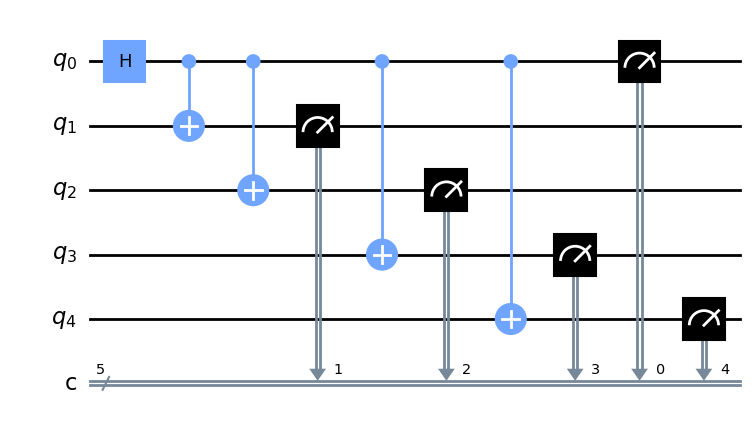

In [10]:
n_qbits = 5
circ = QuantumCircuit(n_qbits, n_qbits)
circ.h(0)
for i in range(n_qbits-1):
    circ.cx(0,i+1)
circ.measure(range(n_qbits), range(n_qbits))
circ.draw('mpl')

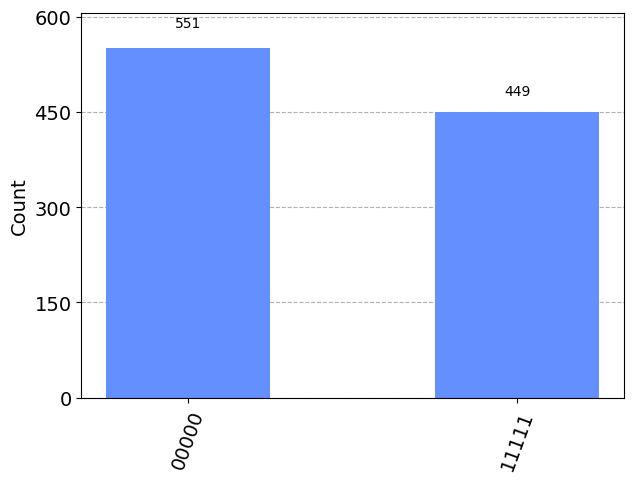

In [11]:
job = execute(circ , simulator , shots=1000)
result = job.result()
counts = result.get_counts(circ)
plot_histogram(counts)

# 4 - Quantum Teleportation

# Initializing bits and the circuit

In [12]:
aliceQubits = QuantumRegister(2, 'a')
aliceCbits_0 = ClassicalRegister(1, 'ac0')
aliceCbits_1 = ClassicalRegister(1, 'ac1')
bobQubits = QuantumRegister(1, 'b')
bobCbits = ClassicalRegister(1, 'bc')

circ = QuantumCircuit(aliceQubits, bobQubits, aliceCbits_0, aliceCbits_1, bobCbits)

# Choosing $\left|\psi\right>$ to teleport

In [13]:
theta = np.pi
phi = 0
lamda = 0

circ.u(theta, phi, lamda, aliceQubits[0])

In [14]:
state = Statevector.from_int(0, 2)

# Evolve the state by the quantum circuit
state = state.evolve(circ)

circ.barrier()

#draw using latex
display(Math(fr'\cos\left(\theta/2\right)={np.cos(theta/2)}\\' + r'e^{i\phi}' + fr'\sin\left(\theta/2\right)={np.exp(1j*phi)*np.sin(theta/2)}'))

expected_p0 = np.cos(theta/2)**2
expected_p1 = np.abs(np.exp(1j*phi)*np.sin(theta/2))**2

display(Math(fr'P_0={expected_p0}'))
display(Math(fr'P_1={expected_p1}'))
state.draw('latex')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

# Creating a Bell pair

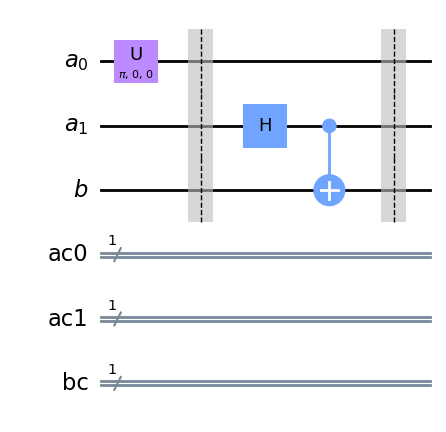

In [15]:
circ.h(aliceQubits[1])
circ.cx(aliceQubits[1], bobQubits[0])
circ.barrier()
circ.draw('mpl')

# Apllying CNOT to Bob's qubit which is part of the Bell pair and using $\left|\psi\right>$ as control.

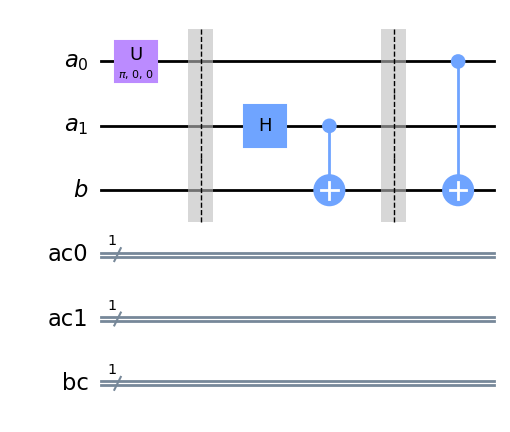

In [16]:
circ.cx(aliceQubits[0], bobQubits[0])
circ.draw('mpl')

# Applying H to Alice's part of the Bell pair

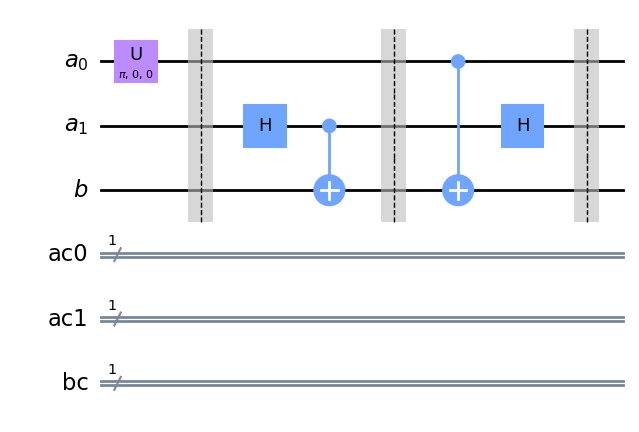

In [17]:
circ.h(aliceQubits[1])
circ.barrier()
circ.draw('mpl')

# Measure Alice's qbits

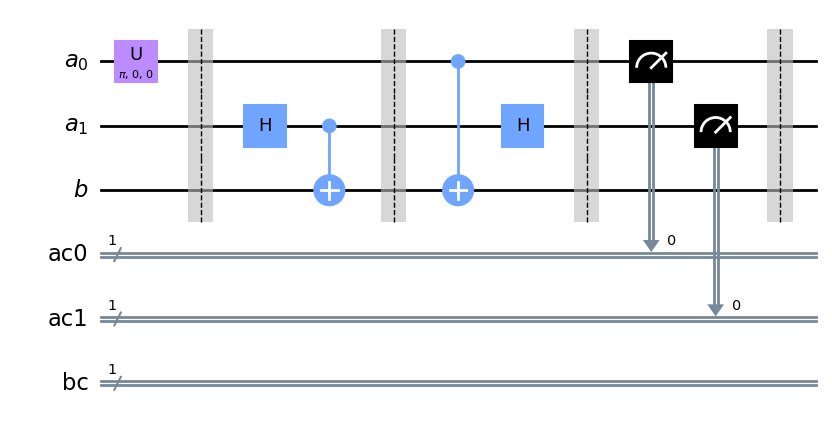

In [18]:
circ.measure(aliceQubits[0], aliceCbits_0[0])
circ.measure(aliceQubits[1], aliceCbits_1[0])
circ.barrier()
circ.draw('mpl')

# If Alice got $\left|00\right>$ Bob has $\left|\psi\right>$, otherwise apply conditional gates on Bob's qubit.
# $\left|10\right> \longrightarrow Z$
# $\left|01\right> \longrightarrow X$
# $\left|11\right> \longrightarrow ZX$

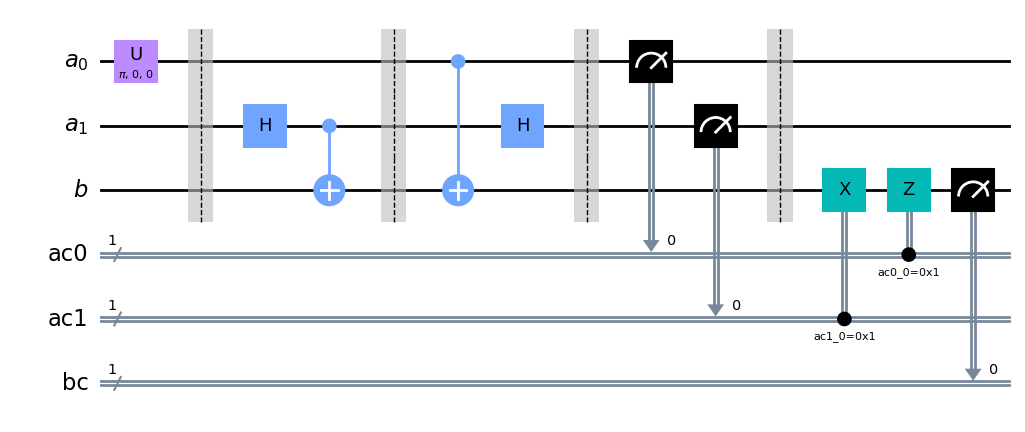

In [19]:
circ.x(bobQubits[0]).c_if(aliceCbits_1[0], 1) 
circ.z(bobQubits[0]).c_if(aliceCbits_0[0], 1)
circ.measure(bobQubits, bobCbits)
circ.draw('mpl')

# Simulating the circuit

In [20]:
n_shots = 1000
job = execute(circ , simulator , shots=n_shots)
result = job.result()
counts = result.get_counts(circ)
print(counts)

{'1 0 1': 253, '0 1 1': 242, '1 1 1': 243, '0 0 1': 262}


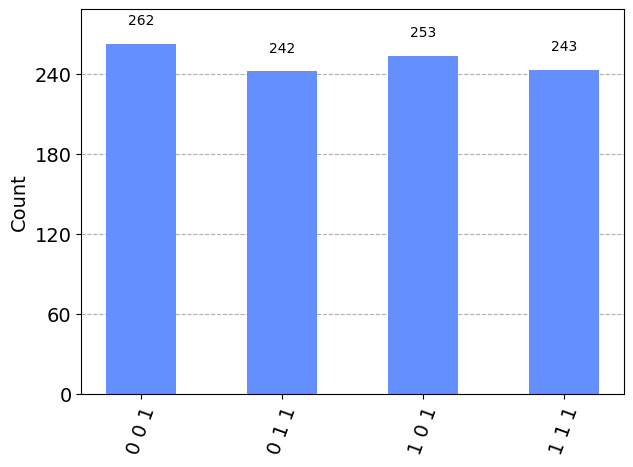

In [21]:
plot_histogram(counts)

# Bob's qubit is the last qubit which is where we want to teleport $\left|\psi\right>$ into.

In [22]:
# if the last qubit is 0
p_0 = (counts['0 10'] + counts['0 00'])/n_shots
# if the last qubit is 1
p_1 = (counts['0 11'] + counts['0 01'])/n_shots

KeyError: '0 10'

In [ ]:
display(Math(r'\text{Expected probability of getting 0 out of }' + fr'\left|\psi\right> = {expected_p0}'))
display(Math(r'\text{probability of getting 0 out of }' + fr'\left|\psi\right> = {p_0}'))
display(Math(r'\text{Expected probability of getting 1 out of }' + fr'\left|\psi\right> = {expected_p1}'))
display(Math(r'\text{probability of getting 1 out of }' + fr'\left|\psi\right> = {p_1}'))

# But what if Bob and Alice are far away? 
# The measurements must be conducted seperetley

In [23]:
aliceQubits = QuantumRegister(2, 'a')
aliceCbits_0 = ClassicalRegister(1, 'ac0')
aliceCbits_1 = ClassicalRegister(1, 'ac1')
bobQubits = QuantumRegister(1, 'b')
bobCbits = ClassicalRegister(1, 'bc')

circ = QuantumCircuit(aliceQubits, bobQubits, aliceCbits_0, aliceCbits_1, bobCbits)

theta = np.pi
phi = np.pi/4
lamda = 0

circ.u(theta, phi, lamda, aliceQubits[0])

state = Statevector.from_int(0, 2)

# Evolve the state by the quantum circuit
state = state.evolve(circ)

#draw using latex
display(Math(fr'\cos\left(\theta/2\right)={np.cos(theta/2)}\\' + r'e^{i\phi}' + fr'\sin\left(\theta/2\right)={np.exp(1j*phi)*np.sin(theta/2)}'))

expected_p0 = np.cos(theta/2)**2
expected_p1 = np.abs(np.exp(1j*phi)*np.sin(theta/2))**2

display(Math(fr'P_0={expected_p0}'))
display(Math(fr'P_1={expected_p1}'))
circ.draw('mpl')
state.draw('latex')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

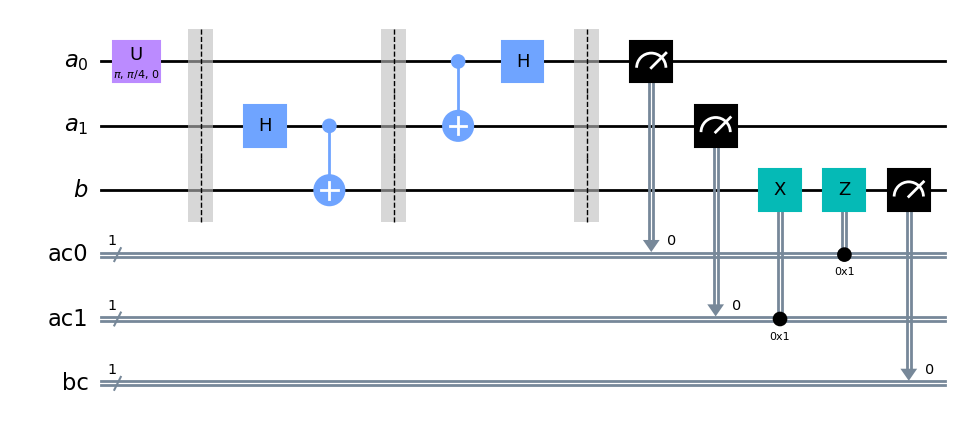

In [24]:
circ.barrier()
circ.h(aliceQubits[1])
circ.cx(aliceQubits[1], bobQubits[0])
circ.barrier()
circ.cx(aliceQubits[0], aliceQubits[1])
circ.h(aliceQubits[0])
circ.barrier()
circ.measure(aliceQubits[0], aliceCbits_0[0])
circ.measure(aliceQubits[1], aliceCbits_1[0])
circ.x(bobQubits[0]).c_if(aliceCbits_1, 1) 
circ.z(bobQubits[0]).c_if(aliceCbits_0, 1) 
circ.measure(bobQubits, bobCbits)
circ.draw('mpl')

{'1 1 1': 237, '1 0 0': 253, '1 1 0': 268, '1 0 1': 242}


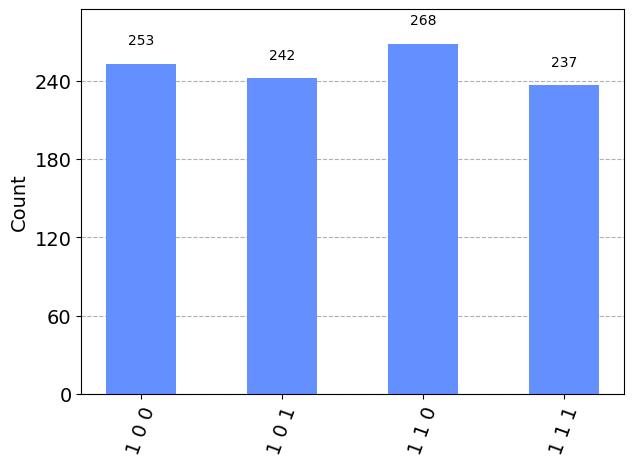

In [25]:
n_shots = 1000
job = execute(circ , simulator , shots=n_shots)
result = job.result()
counts = result.get_counts(circ)
print(counts)
plot_histogram(counts)

In [26]:
# if the last qubit is 0
p_0 = (counts['0 10'] + counts['0 00'] + counts['1 00'] + counts['1 10'])/n_shots
# if the last qubit is 1
p_1 = (counts['0 11'] + counts['0 01'] + counts['1 01'] + counts['1 11'])/n_shots

display(Math(r'\text{Expected probability of getting 0 out of }' + fr'\left|\psi\right> = {expected_p0}'))
display(Math(r'\text{probability of getting 0 out of }' + fr'\left|\psi\right> = {p_0}'))
display(Math(r'\text{Expected probability of getting 1 out of }' + fr'\left|\psi\right> = {expected_p1}'))
display(Math(r'\text{probability of getting 1 out of }' + fr'\left|\psi\right> = {p_1}'))

KeyError: '0 10'